In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.utils import normalize
import glob
import cv2
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU,Concatenate,Input,AveragePooling2D, Activation, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.layers import Lambda,GlobalMaxPooling2D

from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import MeanIoU 
from tensorflow.keras import backend as K

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
input_dir = '/content/drive/Shared drives/ITI_Graduation_Project/dataset/data_semantics/training/image_2/'
target_dir = '/content/drive/Shared drives/ITI_Graduation_Project/dataset/data_semantics/training/semantic/'

In [ ]:
#input_dir = 'dataset/data_semantics/training/image_2'
#target_dir = 'dataset/data_semantics/training/semantic'

In [4]:
train_images = []
for img_path in sorted(glob.glob(os.path.join(input_dir, "*.png"))):
    img = cv2.imread(img_path)       
    img = cv2.resize(img, (128, 128))
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    train_images.append(img)

In [5]:
train_masks = [] 
for mask_path in sorted(glob.glob(os.path.join(target_dir, "*.png"))):
    mask = cv2.imread(mask_path,0)       
    mask = cv2.resize(mask, (128, 128), interpolation = cv2.INTER_NEAREST)
    cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    train_masks.append(mask)

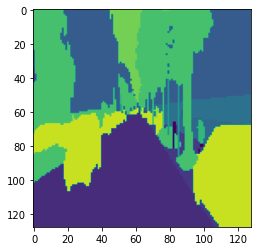

In [6]:
plt.imshow(train_masks[0])

In [7]:
train_images = np.array(train_images , dtype='float32')
train_masks = np.array(train_masks , dtype= 'float32')

In [8]:
from sklearn.model_selection import train_test_split
train_images, test_img, train_masks, test_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

In [9]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w= train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)
np.unique(train_masks_encoded_original_shape)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [10]:
labelencoder = LabelEncoder()
n, h, w= test_masks.shape
test_masks_reshaped = test_masks.reshape(-1,1)
test_masks_reshaped_encoded = labelencoder.fit_transform(test_masks_reshaped)
test_masks_encoded_original_shape = test_masks_reshaped_encoded.reshape(n, h, w)
test_masks = np.expand_dims(test_masks_encoded_original_shape, axis=3)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
train_images = train_images / 255.0
test_img = test_img / 255.0

In [12]:
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 42)

In [13]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y1, num_classes=31)
y_train_cat = train_masks_cat.reshape((y1.shape[0], y1.shape[1], y1.shape[2], 31))



test_masks_cat = to_categorical(y_test, num_classes=31)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], 31))

In [14]:
test_masks_cat = to_categorical(test_masks, num_classes=31)
test_masks_cat = test_masks_cat.reshape((test_masks.shape[0], test_masks.shape[1], test_masks.shape[2], 31))

In [15]:
#======================================================================================================================
#losses
def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)


def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

In [16]:
def jaccard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jaccard_coef_loss(y_true, y_pred):
    return 1.0 - jaccard_coef(y_true, y_pred)

In [17]:
def dice_coef(y_true, y_pred):
    #y_true = tf.cast(y_true, y_pred.dtype)
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
 
    return 1.0 - dice_coef(y_true, y_pred)

In [18]:
#======================================================================================================================

In [19]:
#Unet Model
def convolution_operation(entered_input, filters=64):
    # Taking first input and implementing the first conv block
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    
    # Taking first input and implementing the second conv block
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    
    return act2

def encoder(entered_input, filters=64):
    # Collect the start and end of each sub-block for normal pass and skip connections
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2))(enc1)
    return enc1, MaxPool1

def decoder(entered_input, skip, filters=64):
    # Upsampling and concatenating the essential features
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

def U_Net(Image_Size,num_classes):
    # Take the image size and shape
    input1 = Input(Image_Size)
    
    # Construct the encoder blocks
    skip1, encoder_1 = encoder(input1, 64)
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*16)
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    out = Conv2D(num_classes, 1, padding="same", activation="softmax")(decoder_4)

    model = Model(inputs=[input1], outputs=[out])
    return model

In [20]:
input_shape = (128, 128, 3)
num_classes=31

In [21]:
model_UNet = U_Net(input_shape,num_classes)
model_UNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [22]:
import time
model_UNet.compile(optimizer="adam", loss = jaccard_coef_loss, metrics=["acc", dice_coef , jaccard_coef])

callbacks_UNet = [
    ReduceLROnPlateau(monitor = 'val_loss',
                         patience =20,
                         verbose = 1,
                         factor = 0.3,
                         min_lr = 0.00001),
    ModelCheckpoint(filepath=r'model_UNet-tgs-salt.h5', verbose=0, save_best_only=True, save_weights_only=False)]

start_UNet = time.time()

results_UNet =model_UNet.fit(X1, y_train_cat, batch_size=8, epochs=200, validation_data=(X_test, y_test_cat),callbacks=callbacks_UNet)

end_UNet = time.time()
print("Run time for UNet [s]: ",end_UNet-start_UNet)

Epoch 1/200
18/18 [==============================] - 20s 241ms/step - loss: 0.7953 - acc: 0.5001 - dice_coef: 0.3280 - jaccard_coef: 0.2047 - val_loss: 0.8364 - val_acc: 0.3581 - val_dice_coef: 0.2811 - val_jaccard_coef: 0.1636 - lr: 0.0010
Epoch 2/200
18/18 [==============================] - 4s 215ms/step - loss: 0.6245 - acc: 0.6442 - dice_coef: 0.5437 - jaccard_coef: 0.3755 - val_loss: 0.7804 - val_acc: 0.3940 - val_dice_coef: 0.3601 - val_jaccard_coef: 0.2196 - lr: 0.0010
Epoch 3/200
18/18 [==============================] - 4s 221ms/step - loss: 0.5469 - acc: 0.6683 - dice_coef: 0.6218 - jaccard_coef: 0.4531 - val_loss: 0.7505 - val_acc: 0.4341 - val_dice_coef: 0.3993 - val_jaccard_coef: 0.2495 - lr: 0.0010
Epoch 4/200
18/18 [==============================] - 3s 152ms/step - loss: 0.5100 - acc: 0.6767 - dice_coef: 0.6557 - jaccard_coef: 0.4900 - val_loss: 0.7936 - val_acc: 0.4114 - val_dice_coef: 0.3420 - val_jaccard_coef: 0.2064 - lr: 0.0010
Epoch 5/200
18/18 [====================

In [23]:
#model_UNet.save('unet.h5')

In [24]:
import pickle
with open('unet.pickle' , 'wb') as file:
  pickle.dump(results_UNet.history,file)

In [25]:
pred_train = model_UNet.predict(X1)
pred_val = model_UNet.predict(X_test)
pred_test = model_UNet.predict(test_img)

In [26]:
pred_train1 = np.argmax(pred_train, axis = 3)
pred_val1 = np.argmax(pred_val, axis = 3)
pred_test1 = np.argmax(pred_test, axis = 3)

In [27]:
miou = tf.keras.metrics.MeanIoU(num_classes= 31)
miou.update_state(y_train_cat, pred_train)
miou.result().numpy()

0.47140238

In [28]:
miou = tf.keras.metrics.MeanIoU(num_classes= 31)
miou.update_state(y_test_cat, pred_val)
miou.result().numpy()

0.5090857

In [29]:
miou = tf.keras.metrics.MeanIoU(num_classes= 31)
miou.update_state(test_masks_cat, pred_test)
miou.result().numpy()

0.48454654

In [ ]:
#===========================================================================================================================

In [30]:
#PSP

In [31]:
inputs = Input((128, 128, 3))
s = inputs
resnet = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=s)
x = resnet.get_layer("conv2_block3_2_relu").output
x = Conv2D(filters=64,kernel_size=(3, 3), dilation_rate= 3 ,activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = Dropout(0.1)(x)

x = Conv2D(filters=128 ,kernel_size=(3, 3), dilation_rate= 3 ,activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = Dropout(0.1)(x)

#base Pooling
base = GlobalAveragePooling2D()(x)
reshaped = tf.keras.layers.Reshape((1,1,128))(base)

#first conv
first_conv = Conv2D(filters=32,kernel_size=(1,1), activation='relu', kernel_initializer='he_normal', padding='same')(reshaped)
first_up = UpSampling2D(size=32,interpolation='bilinear')(first_conv)


#second conv
second = AveragePooling2D(pool_size=(2,2))(x)
second_conv = Conv2D(filters=32,kernel_size=(1,1), activation='relu', kernel_initializer='he_normal', padding='same')(second)
second_up = UpSampling2D(size=2,interpolation='bilinear')(second_conv)


#third conv
third = AveragePooling2D(pool_size=(4,4))(x)
third_conv = Conv2D(filters=32,kernel_size=(1,1), activation='relu', kernel_initializer='he_normal', padding='same')(third)
third_up = UpSampling2D(size=4,interpolation='bilinear')(third_conv)

#fourth
fourth = AveragePooling2D(pool_size=(8,8))(x)
fourth_conv = Conv2D(filters=32,kernel_size=(1,1), activation='relu', kernel_initializer='he_normal', padding='same')(fourth)
fourth_up = UpSampling2D(size=8,interpolation='bilinear')(fourth_conv)

concated = tf.keras.layers.concatenate([x,first_up,second_up,third_up,fourth_up])
X = Conv2DTranspose(128, (2, 2), strides=2, padding="same")(concated)

X = Conv2D(filters=64,kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(X)
X = Dropout(0.1)(X)
X = BatchNormalization()(X)

X = Conv2DTranspose(64, (2, 2), strides=2, padding="same")(X)

X = Conv2D(filters=32,kernel_size=(3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(X)
X = Dropout(0.1)(X)
X = BatchNormalization()(X)

outputs = Conv2D(31, (1, 1), activation='softmax')(X)

94781440/94765736 [==============================] - 1s 0us/step


In [32]:
model_psp = Model(inputs=[inputs], outputs=[outputs])
model_psp.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [33]:
model_psp.compile(optimizer='adam', 
              loss= dice_coef_loss,
              metrics=[jaccard_coef,dice_coef,'accuracy'])

In [34]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',
                         patience =20,
                         verbose = 1,
                         factor = 0.3,
                         min_lr = 0.00001)

mcp = ModelCheckpoint(filepath=r"model.h5", 
    save_weights_only=True,
    monitor='val_jaccard_coef',
    mode='auto',
    verbose=0,
    save_best_only=False)

In [35]:
now = time.time()
history = model_psp.fit(X1, y_train_cat, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=200, 
                    validation_data=(X_test, y_test_cat),shuffle=True,
                   callbacks = [lrd , mcp])
end = time.time()
print('time: ', end - now)

Epoch 1/200
18/18 [==============================] - 4s 74ms/step - loss: 0.8763 - jaccard_coef: 0.0667 - dice_coef: 0.1237 - accuracy: 0.1862 - val_loss: 0.8990 - val_jaccard_coef: 0.0532 - val_dice_coef: 0.1010 - val_accuracy: 0.1496 - lr: 0.0010
Epoch 2/200
18/18 [==============================] - 1s 48ms/step - loss: 0.7089 - jaccard_coef: 0.1714 - dice_coef: 0.2911 - accuracy: 0.3615 - val_loss: 0.8844 - val_jaccard_coef: 0.0613 - val_dice_coef: 0.1156 - val_accuracy: 0.1326 - lr: 0.0010
Epoch 3/200
18/18 [==============================] - 1s 47ms/step - loss: 0.6310 - jaccard_coef: 0.2266 - dice_coef: 0.3690 - accuracy: 0.4132 - val_loss: 0.8416 - val_jaccard_coef: 0.0860 - val_dice_coef: 0.1584 - val_accuracy: 0.1689 - lr: 0.0010
Epoch 4/200
18/18 [==============================] - 1s 46ms/step - loss: 0.6028 - jaccard_coef: 0.2481 - dice_coef: 0.3972 - accuracy: 0.4265 - val_loss: 0.8467 - val_jaccard_coef: 0.0830 - val_dice_coef: 0.1533 - val_accuracy: 0.1655 - lr: 0.0010
Epoc

In [ ]:
#model_psp.save('psp.h5')

In [36]:
with open('psp.pickle' , 'wb') as file:
  pickle.dump(history.history,file)

In [37]:
pred_train = model_psp.predict(X1)
pred_val = model_psp.predict(X_test)
pred_test = model_psp.predict(test_img)

In [38]:
pred_train1 = np.argmax(pred_train, axis = 3)
pred_val1 = np.argmax(pred_val, axis = 3)
pred_test1 = np.argmax(pred_test, axis = 3)

In [39]:
miou = tf.keras.metrics.MeanIoU(num_classes= 31)
miou.update_state(y_train_cat, pred_train)
miou.result().numpy()

0.4426431

In [40]:
miou = tf.keras.metrics.MeanIoU(num_classes= 31)
miou.update_state( y_test_cat, pred_val)
miou.result().numpy()

0.48635918

In [41]:
miou = tf.keras.metrics.MeanIoU(num_classes= 31)
miou.update_state(test_masks_cat, pred_test)
miou.result().numpy()

0.48179647

In [42]:
#========================================================================================================================

In [43]:
#DeepLab

In [44]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


In [45]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = Dropout(0.2)(x)
    x = convolution_block(x)
    x = Dropout(0.1)(x)
    x = UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    x = Dropout(0.1)(x)
    model_output = Conv2D(num_classes, kernel_size=(1, 1), activation='softmax')(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model_deeplab = DeeplabV3Plus(image_size=128, num_classes=31)
model_deeplab.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

In [46]:
model_deeplab.compile(optimizer='adam', 
              loss= dice_coef_loss,
              metrics=[jaccard_coef,dice_coef,'accuracy'])

In [47]:
now = time.time()
history1 = model_deeplab.fit(X1, y_train_cat, 
                    batch_size = 8, 
                    verbose=1, 
                    epochs=200, 
                    validation_data=(X_test, y_test_cat),shuffle=True,
                   callbacks = [lrd , mcp])
end = time.time()
print('time: ', end - now)

Epoch 1/200
18/18 [==============================] - 10s 166ms/step - loss: 0.4592 - jaccard_coef: 0.3865 - dice_coef: 0.5408 - accuracy: 0.5726 - val_loss: 0.7340 - val_jaccard_coef: 0.1534 - val_dice_coef: 0.2660 - val_accuracy: 0.2662 - lr: 0.0010
Epoch 2/200
18/18 [==============================] - 2s 111ms/step - loss: 0.3486 - jaccard_coef: 0.4845 - dice_coef: 0.6514 - accuracy: 0.6538 - val_loss: 0.8171 - val_jaccard_coef: 0.1007 - val_dice_coef: 0.1829 - val_accuracy: 0.1825 - lr: 0.0010
Epoch 3/200
18/18 [==============================] - 2s 113ms/step - loss: 0.3092 - jaccard_coef: 0.5291 - dice_coef: 0.6908 - accuracy: 0.6951 - val_loss: 0.8405 - val_jaccard_coef: 0.0867 - val_dice_coef: 0.1595 - val_accuracy: 0.1598 - lr: 0.0010
Epoch 4/200
18/18 [==============================] - 2s 113ms/step - loss: 0.2816 - jaccard_coef: 0.5614 - dice_coef: 0.7184 - accuracy: 0.7220 - val_loss: 0.7112 - val_jaccard_coef: 0.1688 - val_dice_coef: 0.2888 - val_accuracy: 0.2908 - lr: 0.0010

In [48]:
#model_deeplab.save('deeplab.h5')

In [49]:
#import pickle
#with open('deeplab.pickle' , 'wb') as file:
  #pickle.dump(history1.history,file)

In [50]:
pred_train = model_deeplab.predict(X1)
pred_val = model_deeplab.predict(X_test)
pred_test = model_deeplab.predict(test_img)

In [51]:
pred_train1 = np.argmax(pred_train, axis = 3)
pred_val1 = np.argmax(pred_val, axis = 3)
pred_test1 = np.argmax(pred_test, axis = 3)

In [52]:
miou = tf.keras.metrics.MeanIoU(num_classes= 31)
miou.update_state(y_train_cat, pred_train)
miou.result().numpy()

0.7549277

In [53]:
miou = tf.keras.metrics.MeanIoU(num_classes= 31)
miou.update_state(y_test_cat, pred_val)
miou.result().numpy()

0.70722127

In [54]:
miou = tf.keras.metrics.MeanIoU(num_classes= 31)
miou.update_state(test_masks_cat, pred_test)
miou.result().numpy()

0.5335441